In [4]:
!pip install yfinance
!pip install pandas
!pip install matplotlib
!pip install scikit-learn


In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [6]:
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')

[*********************100%%**********************]  1 of 1 completed


In [7]:
df = data['Close'].values.reshape(-1, 1)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [9]:
training_size = int(len(df) * 0.75)
train_data, test_data = df[0:training_size, :], df[training_size:len(df), :]

In [10]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
8/8 [==============================] - 10s 434ms/step - loss: 0.1177 - val_loss: 0.0243
Epoch 2/100
8/8 [==============================] - 1s 175ms/step - loss: 0.0182 - val_loss: 0.0140
Epoch 3/100
8/8 [==============================] - 1s 164ms/step - loss: 0.0105 - val_loss: 0.0114
Epoch 4/100
8/8 [==============================] - 1s 167ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 5/100
8/8 [==============================] - 1s 172ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 6/100
8/8 [==============================] - 1s 168ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 7/100
8/8 [==============================] - 1s 171ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 8/100
8/8 [==============================] - 2s 226ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 9/100
8/8 [==============================] - 2s 279ms/step - loss: 0.0031 - val_loss: 0.0059
Epoch 10/100
8/8 [==============================] - 2s 255ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 11

In [14]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

3/3 [==============================] - 0s 31ms/step


In [15]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [16]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))
math.sqrt(mean_squared_error(y_test, test_predict))

148.1115357120813

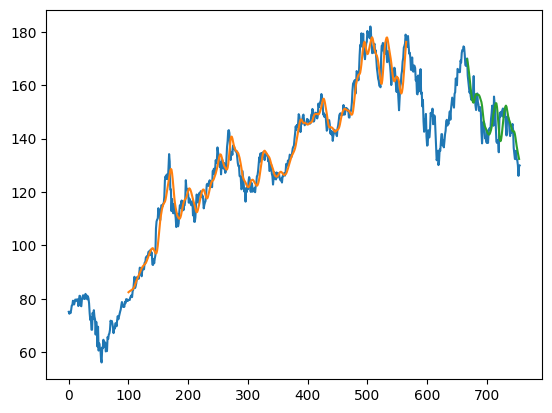

In [17]:
look_back = time_step
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(df) - 1, :] = test_predict

import matplotlib.pyplot as plt

plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()